In [2]:
import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time

### Analysis of the Images (one Tumor per Image)
The aim of this analysis is to test if it is possible to destinguish between the 2 different tumours types. Therefore the net is trained with with the cropped images of the 2 tumour types.

#### Creation of Training, Validation and Testset
Approx 60% is for training, 20% for validation and 20% for testing. The borders are choosen so that no patient is splitt between the different sets.

In [4]:
start = time.time()
#Inselspital
with gzip.open('GBM_tumors.pickle.gz') as f:
    Names,X,Y = pickle.load(f)
print ("Loaded data in " + str(time.time() - start))
print ("   " + str(X.shape) + " y " + str(Y.shape))


gbm_test = 408

Y_train = Y[:gbm_test]
Y_test  = Y[gbm_test:]

X_train = X[:gbm_test,:,:,:]
X_test  = X[gbm_test:,:,:]

Loaded data in 0.123533964157
   (500, 1, 48, 48) y (500,)


In [5]:
start = time.time()
#Inselspital
with gzip.open('META_tumors.pickle.gz') as f:
    Names,X,Y = pickle.load(f)
print ("Loaded data in " + str(time.time() - start))
print ("   " + str(X.shape) + " y " + str(Y.shape))


meta_test = 340

Y_train = np.append(Y_train, Y[:meta_test])
Y_test = np.append(Y_test, Y[meta_test:])

X_train = np.concatenate((X_train, X[:meta_test,:,:,:]), axis=0)
X_test = np.concatenate((X_test, X[meta_test:,:,:,:]), axis=0)

Loaded data in 0.098995923996
   (429, 1, 48, 48) y (429,)


#### Random Permutations of the training set
In order that the minibatch sees as much variation of the data as possible, we permute the trainingset.

In [6]:
perm = np.random.permutation(len(Y_train))
X = X_train[perm,:,:,:]
y = Y_train[perm]

y = np.asarray(y - 1,dtype='int32')
X = np.asanyarray(X,dtype='float32')

In [7]:
print(str(np.shape(X)) + " " + str(np.shape(y)))
print(str(np.shape(X_test)) + " " + str(np.shape(Y_test)))
y[1:10]

(748, 1, 48, 48) (748,)
(181, 1, 48, 48) (181,)


array([1, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

### Normalization (Optional)

In [8]:
## Training
Xmean = X_train.mean(axis = 0)
XStd = np.sqrt(X_train.var(axis=0))
X_train = (X_train-Xmean)/(XStd + 0.01)

## Testing
Xmean = X_test.mean(axis = 0)
XStd = np.sqrt(X_test.var(axis=0))
X_test = (X_test-Xmean)/(XStd + 0.01)

#### The first try

In [9]:
PIXELS = 48

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    dropout1_p=0.0,
    
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_pool_size=(2, 2),
    dropout2_p=0.3,
    
    hidden3_num_units=100,
    dropout3_p=0.3,
    
    hidden4_num_units=20,
    dropout4_p=0.3,
    
    output_num_units=3, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=200,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: GeForce GTX 780


In [10]:
net = net1.fit(X,y)

# Neural Network with 661511 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 1x48x48  |
|   1 | conv1    | 32x44x44 |
|   2 | pool1    | 32x22x22 |
|   3 | dropout1 | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | pool2    | 64x10x10 |
|   6 | dropout2 | 64x10x10 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 3        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.08573       1.04779      1.03622      0.37855  0.24s
      2       1.01225       0.95461      1.06038      0.37855  0.22s
      3       0.91742       0.84295      1.08833      0.37855  0.21s
      4       0.82414       0.73183      1.12613      0.62145  0.21s
      5       0.77443       0.68850      1.12480      0.62145  0.21s
      6       0.75844    

/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


In [11]:
y[1:10]

array([1, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

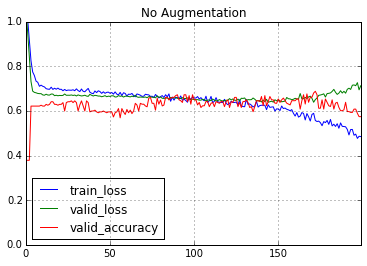

In [12]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(net.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))

In [13]:
X_test = np.asanyarray(X_test,dtype='float32')
pred = net.predict(X_test)
np.sum(pred  == np.asanyarray(Y_test - 1, dtype='int32')) / (1.0*len(Y_test))

0.63535911602209949